In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# LSTM

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0253
Epoch 2/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0012
Epoch 3/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0012
Epoch 4/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 8.3329e-04
Epoch 5/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 5.4160e-04
Epoch 6/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 6.2889e-04
Epoch 7/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 4.6745e-04
Epoch 8/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 5.3708e-04
Epoch 9/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 4.7061e-04
Epoch 10/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 2.9120e-04
Epoch 11/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 2.5749e-04
Epoch 12/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.7488e-04
Epoch 13/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 2.1693e-04
Epoch 14/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.2062e-04
Epoch 15/

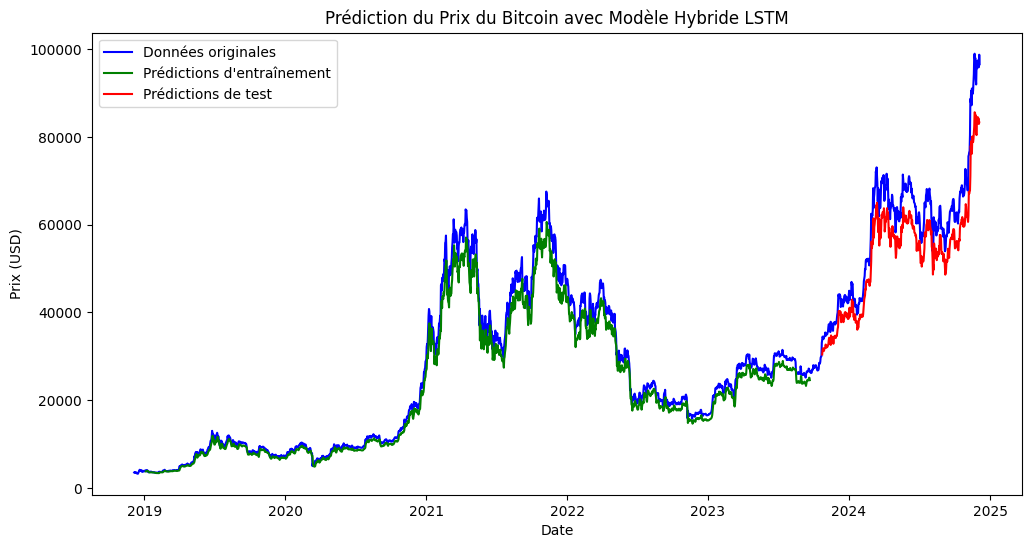

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def charger_donnees(file_path):
    """Charger les données à partir d'un fichier CSV"""
    bist100 = pd.read_csv(file_path)
    bist100 = bist100.rename(columns={
        'Date': 'date', 'Open': 'open', 'High': 'high', 
        'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'
    })
    bist100['date'] = pd.to_datetime(bist100['date'])
    bist100.sort_values(by='date', inplace=True)
    return bist100[['date', 'close']]

def preparer_donnees(close_stock):
    """Préparer les données en remplissant les NaN et en appliquant la transformation log"""
    close_stock.dropna(subset=['close'], inplace=True)
    close_stock['close'].fillna(close_stock['close'].mean(), inplace=True)
    close_stock['close'].replace([np.inf, -np.inf], close_stock['close'].max(), inplace=True)
    close_stock['close'] = np.log1p(close_stock['close'])
    return close_stock

def scaler_donnees(close_stock):
    """Appliquer le MinMaxScaler pour la mise à l'échelle"""
    scaler = MinMaxScaler(feature_range=(0, 1))
    closedf = scaler.fit_transform(close_stock[['close']])
    return closedf, scaler

def separer_donnees(closedf, ratio=0.8):
    """Séparer les données en ensembles d'entraînement et de test"""
    training_size = int(len(closedf) * ratio)
    test_size = len(closedf) - training_size
    train_data, test_data = closedf[0:training_size, :], closedf[training_size:len(closedf), :1]
    return train_data, test_data

def create_dataset(dataset, time_step=1):
    """Convertir un tableau de valeurs en un jeu de données"""
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

def construire_modele(time_step):
    """Construire le modèle LSTM"""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def entrainer_modele(model, X_train, y_train, epochs=20, batch_size=5):
    """Entraîner le modèle LSTM"""
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history

def evaluer_model(model, X_train, y_train, X_test, y_test, scaler, close_stock, time_step):
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
    original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Inverser la transformation logarithmique
    train_predict = np.expm1(train_predict)
    test_predict = np.expm1(test_predict)
    original_ytrain = np.expm1(original_ytrain)
    original_ytest = np.expm1(original_ytest)
    
    train_rmse = math.sqrt(mean_squared_error(original_ytrain, train_predict))
    test_rmse = math.sqrt(mean_squared_error(original_ytest, test_predict))
    test_mae = mean_absolute_error(original_ytest, test_predict)
    train_r2 = r2_score(original_ytrain, train_predict)
    test_r2 = r2_score(original_ytest, test_predict)
    
    last_10_dates = close_stock['date'][-len(original_ytest):].iloc[-10:]
    real_values_last_10 = original_ytest[-10:]
    predicted_values_last_10 = test_predict[-10:]
    
    result_df = pd.DataFrame({
        'Date': last_10_dates.values,
        'Real Values': real_values_last_10.flatten(),
        'Predicted Values': predicted_values_last_10.flatten()
    })
    
    print("\n10 dernières valeurs réelles et prédites :")
    print(result_df)
    
    return train_rmse, test_rmse, test_mae, train_r2, test_r2, train_predict, test_predict


def preparer_donnees(close_stock):
    """Préparer les données en remplissant les NaN et en appliquant la transformation log"""
    close_stock = close_stock.copy()
    close_stock.dropna(subset=['close'], inplace=True)
    if close_stock['close'].isnull().any():
        close_stock['close'].fillna(close_stock['close'].mean(), inplace=True)
    if np.isinf(close_stock['close']).any():
        close_stock['close'].replace([np.inf, -np.inf], close_stock['close'].max(), inplace=True)
    close_stock['close'] = np.log1p(close_stock['close'])
    return close_stock
def afficher_resultats(train_predict, test_predict, closedf, time_step, close_stock, scaler):
    """Afficher les résultats avec les prix réels"""
    # Convertir les données en prix réels
    real_prices = np.expm1(scaler.inverse_transform(closedf))
    train_predict_plot = np.empty_like(closedf)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
    
    test_predict_plot = np.empty_like(closedf)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(closedf) - 1, :] = test_predict
    
    plt.figure(figsize=(12, 6))
    plt.plot(close_stock['date'], real_prices, label='Données originales', color='blue')
    plt.plot(close_stock['date'], train_predict_plot, label='Prédictions d\'entraînement', color='green')
    plt.plot(close_stock['date'], test_predict_plot, label='Prédictions de test', color='red')
    plt.title('Prédiction du Prix du Bitcoin avec Modèle Hybride LSTM')
    plt.xlabel('Date')
    plt.ylabel('Prix (USD)')
    plt.legend()
    plt.show()

def main(file_path):
    """Fonction principale pour l'exécution du code"""
    close_stock = charger_donnees(file_path)
    close_stock = preparer_donnees(close_stock)
    closedf, scaler = scaler_donnees(close_stock)

    # Séparer les données en ensemble d'entraînement et de test
    train_data, test_data = separer_donnees(closedf)

    # Créer les datasets pour l'entraînement et le test
    time_step = 30
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshaper les données pour LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Construire le modèle LSTM
    model = construire_modele(time_step)

    # Entraîner le modèle
    history = entrainer_modele(model, X_train, y_train, epochs=20, batch_size=5)

    # Évaluer les performances
    train_rmse, test_rmse, test_mae, train_r2, test_r2, train_predict, test_predict = evaluer_model(
        model, X_train, y_train, X_test, y_test, scaler, close_stock, time_step
    )

    # Afficher les résultats
    print(f"Train data RMSE: {train_rmse}")
    print(f"Test data RMSE: {test_rmse}")
    print(f"Test data MAE: {test_mae}")
    print(f"Train data R^2: {train_r2}")
    print(f"Test data R^2: {test_r2}")

    afficher_resultats(train_predict, test_predict, closedf, time_step, close_stock, scaler)


# Exécuter la fonction principale
file_path = '/kaggle/input/dataset/cleaned_BTC-USD.csv'  # Remplacer par votre fichier de données
main(file_path)

# Hybrid LSTM-Linear Regressor 

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0165
Epoch 2/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0011
Epoch 3/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 8.5503e-04
Epoch 4/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 6.8645e-04
Epoch 5/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 5.5988e-04
Epoch 6/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 4.5834e-04
Epoch 7/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 5.7476e-04
Epoch 8/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 3.6361e-04
Epoch 9/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 4.1833e-04
Epoch 10/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 2.2840e-04
Epoch 11/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 3.6160e-04
Epoch 12/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 2.1323e-04
Epoch 13/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 2.0458e-04
Epoch 14/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 2.5279e-04
Epoch

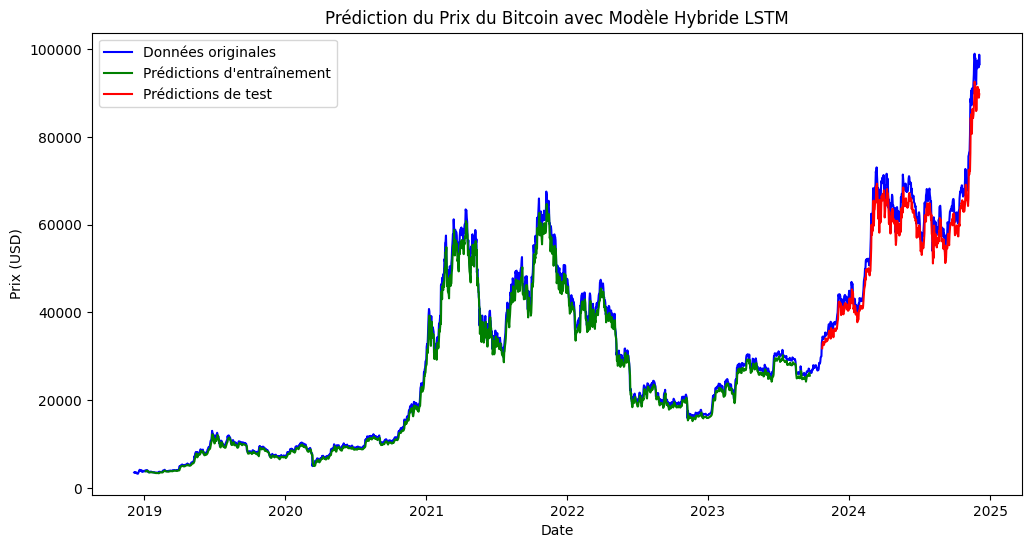

In [2]:
def charger_donnees(file_path):
    bist100 = pd.read_csv(file_path)
    bist100 = bist100.rename(columns={
        'Date': 'date', 'Open': 'open', 'High': 'high', 
        'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'
    })
    bist100['date'] = pd.to_datetime(bist100['date'])
    bist100.sort_values(by='date', inplace=True)
    return bist100[['date', 'close']]

def preparer_donnees(close_stock):
    close_stock = close_stock.copy()
    close_stock.dropna(subset=['close'], inplace=True)
    if close_stock['close'].isnull().any():
        close_stock['close'].fillna(close_stock['close'].mean(), inplace=True)
    if np.isinf(close_stock['close']).any():
        close_stock['close'].replace([np.inf, -np.inf], close_stock['close'].max(), inplace=True)
    close_stock['close'] = np.log1p(close_stock['close'])
    return close_stock

def scaler_donnees(close_stock):
    scaler = MinMaxScaler(feature_range=(0, 1))
    closedf = scaler.fit_transform(close_stock[['close']])
    return closedf, scaler

def separer_donnees(closedf, ratio=0.8):
    training_size = int(len(closedf) * ratio)
    train_data, test_data = closedf[0:training_size, :], closedf[training_size:len(closedf), :1]
    return train_data, test_data

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

def construire_modele(time_step):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def entrainer_modele(model, X_train, y_train, epochs=20, batch_size=5):
    return model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

def evaluer_model(model, X_train, y_train, X_test, y_test, scaler, close_stock, time_step):
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
    original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Inverser la transformation logarithmique
    train_predict = np.expm1(train_predict)
    test_predict = np.expm1(test_predict)
    original_ytrain = np.expm1(original_ytrain)
    original_ytest = np.expm1(original_ytest)
    
    train_rmse = math.sqrt(mean_squared_error(original_ytrain, train_predict))
    test_rmse = math.sqrt(mean_squared_error(original_ytest, test_predict))
    test_mae = mean_absolute_error(original_ytest, test_predict)
    train_r2 = r2_score(original_ytrain, train_predict)
    test_r2 = r2_score(original_ytest, test_predict)
    
    last_10_dates = close_stock['date'][-len(original_ytest):].iloc[-10:]
    real_values_last_10 = original_ytest[-10:]
    predicted_values_last_10 = test_predict[-10:]
    
    result_df = pd.DataFrame({
        'Date': last_10_dates.values,
        'Real Values': real_values_last_10.flatten(),
        'Predicted Values': predicted_values_last_10.flatten()
    })
    
    print("\n10 dernières valeurs réelles et prédites :")
    print(result_df)
    
    return train_rmse, test_rmse, test_mae, train_r2, test_r2, train_predict, test_predict

def afficher_resultats(train_predict, test_predict, closedf, time_step, close_stock, scaler):
    """Afficher les résultats avec les prix réels"""
    # Convertir les données en prix réels
    real_prices = np.expm1(scaler.inverse_transform(closedf))
    train_predict_plot = np.empty_like(closedf)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
    
    test_predict_plot = np.empty_like(closedf)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(closedf) - 1, :] = test_predict
    
    plt.figure(figsize=(12, 6))
    plt.plot(close_stock['date'], real_prices, label='Données originales', color='blue')
    plt.plot(close_stock['date'], train_predict_plot, label='Prédictions d\'entraînement', color='green')
    plt.plot(close_stock['date'], test_predict_plot, label='Prédictions de test', color='red')
    plt.title('Prédiction du Prix du Bitcoin avec Modèle Hybride LSTM')
    plt.xlabel('Date')
    plt.ylabel('Prix (USD)')
    plt.legend()
    plt.show()

def main(file_path):
    close_stock = charger_donnees(file_path)
    close_stock = preparer_donnees(close_stock)
    closedf, scaler = scaler_donnees(close_stock)
    
    train_data, test_data = separer_donnees(closedf)
    
    time_step = 30
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    model = construire_modele(time_step)
    history = entrainer_modele(model, X_train, y_train)
    
    train_rmse, test_rmse, test_mae, train_r2, test_r2, train_predict, test_predict = evaluer_model(
        model, X_train, y_train, X_test, y_test, scaler, close_stock, time_step
    )
    
    print(f"Train data RMSE: {train_rmse}")
    print(f"Test data RMSE: {test_rmse}")
    print(f"Test data MAE: {test_mae}")
    print(f"Train data R^2: {train_r2}")
    print(f"Test data R^2: {test_r2}")
    
    afficher_resultats(train_predict, test_predict, closedf, time_step, close_stock, scaler)

file_path = '/kaggle/input/dataset/cleaned_BTC-USD.csv'
main(file_path)

# ANN

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0806
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 13/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048
Epoch 14/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050
Epoch 15/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043
Epoch 16/50
55/55 ━━━━━━━━━━━━

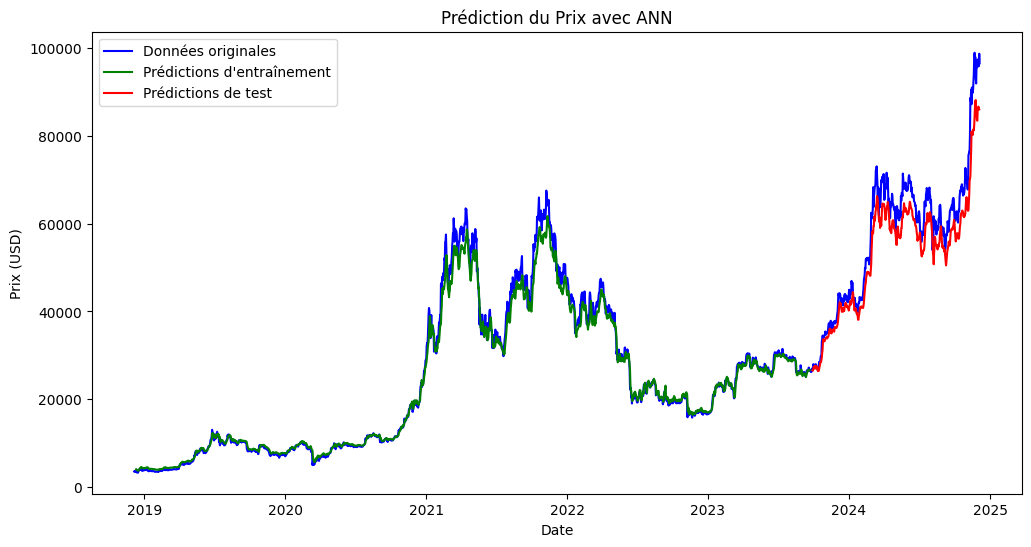

In [5]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Charger les données
def charger_donnees(file_path):
    bist100 = pd.read_csv(file_path)
    bist100 = bist100.rename(columns={
        'Date': 'date', 'Open': 'open', 'High': 'high', 
        'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'
    })
    bist100['date'] = pd.to_datetime(bist100['date'])
    bist100.sort_values(by='date', inplace=True)
    return bist100[['date', 'close']]

# Préparer les données
def preparer_donnees(close_stock):
    close_stock.dropna(subset=['close'], inplace=True)
    close_stock['close'] = np.log1p(close_stock['close'])
    return close_stock

# Appliquer le MinMaxScaler
def scaler_donnees(close_stock):
    scaler = MinMaxScaler(feature_range=(0, 1))
    closedf = scaler.fit_transform(close_stock[['close']])
    return closedf, scaler

# Séparer les données en entraînement et test
def separer_donnees(closedf, ratio=0.8):
    training_size = int(len(closedf) * ratio)
    train_data, test_data = closedf[0:training_size, :], closedf[training_size:len(closedf), :1]
    return train_data, test_data

# Créer un jeu de données avec un pas de temps
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Construire le modèle ANN amélioré
def construire_modele_ann(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Couche de sortie
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Évaluer le modèle
def evaluer_model(model, X_train, y_train, X_test, y_test, scaler, close_stock):
    """Faire des prédictions et évaluer les performances"""
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Inverser la transformation
    train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
    original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Inverser la transformation logarithmique
    train_predict = np.expm1(train_predict)
    test_predict = np.expm1(test_predict)
    original_ytrain = np.expm1(original_ytrain)
    original_ytest = np.expm1(original_ytest)
    
    train_rmse = math.sqrt(mean_squared_error(original_ytrain, train_predict))
    test_rmse = math.sqrt(mean_squared_error(original_ytest, test_predict))
    test_mae = mean_absolute_error(original_ytest, test_predict)
    train_r2 = r2_score(original_ytrain, train_predict)
    test_r2 = r2_score(original_ytest, test_predict)
    
    last_10_dates = close_stock['date'][-len(original_ytest):].iloc[-10:]
    real_values_last_10 = original_ytest[-10:]
    predicted_values_last_10 = test_predict[-10:]
    
    result_df = pd.DataFrame({
        'Date': last_10_dates.values,
        'Real Values': real_values_last_10.flatten(),
        'Predicted Values': predicted_values_last_10.flatten()
    })
    
    print("\n10 dernières valeurs réelles et prédites :")
    print(result_df)
    
    return train_rmse, test_rmse, test_mae, train_r2, test_r2, train_predict, test_predict


# Afficher les résultats
def afficher_resultats(train_predict, test_predict, closedf, time_step, close_stock, scaler):
    """Afficher les résultats avec les prix réels"""
    # Convertir les données en prix réels
    real_prices = np.expm1(scaler.inverse_transform(closedf))
    train_predict_plot = np.empty_like(closedf)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
    
    test_predict_plot = np.empty_like(closedf)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(closedf) - 1, :] = test_predict
    
    plt.figure(figsize=(12, 6))
    plt.plot(close_stock['date'], real_prices, label='Données originales', color='blue')
    plt.plot(close_stock['date'], train_predict_plot, label='Prédictions d\'entraînement', color='green')
    plt.plot(close_stock['date'], test_predict_plot, label='Prédictions de test', color='red')
    plt.title('Prédiction du Prix avec ANN')
    plt.xlabel('Date')
    plt.ylabel('Prix (USD)')
    plt.legend()
    plt.show()


# Fonction principale
def main(file_path):
    close_stock = charger_donnees(file_path)
    close_stock = preparer_donnees(close_stock)
    closedf, scaler = scaler_donnees(close_stock)
    
    train_data, test_data = separer_donnees(closedf)
    
    time_step = 5
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    
    model = construire_modele_ann(input_dim=X_train.shape[1])
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    train_rmse, test_rmse, test_mae, train_r2, test_r2, train_predict, test_predict = evaluer_model(
        model, X_train, y_train, X_test, y_test, scaler, close_stock
    )
    
    print(f"Train data RMSE: {train_rmse}")
    print(f"Test data RMSE: {test_rmse}")
    print(f"Test data MAE: {test_mae}")
    print(f"Train data R^2: {train_r2}")
    print(f"Test data R^2: {test_r2}")
    
    afficher_resultats(train_predict, test_predict, closedf, time_step, close_stock, scaler)


# Exécution
file_path = '/kaggle/input/dataset/cleaned_BTC-USD.csv'  # Remplacez par votre chemin de fichier
main(file_path)


# BILSTM

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0226
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 8.2478e-04
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 7.4972e-04
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 8.5633e-04
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 6.1591e-04
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 5.9214e-04
Epoch 7/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 5.3216e-04
Epoch 8/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 5.0056e-04
Epoch 9/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3.8719e-04
Epoch 10/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 3.5068e-04
Epoch 11/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.7531e-04
Epoch 12/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3.1211e-04
Epoch 13/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3.6102e-04
Epoch 14/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3.4867e-04
E

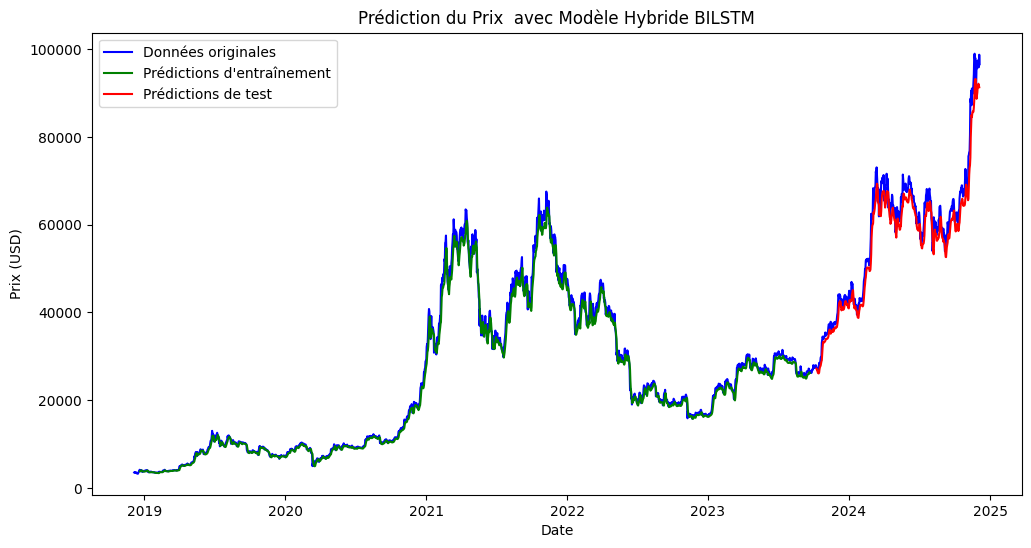

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

def charger_donnees(file_path):
    """Charger les données à partir d'un fichier CSV"""
    bist100 = pd.read_csv(file_path)
    bist100 = bist100.rename(columns={
        'Date': 'date', 'Open': 'open', 'High': 'high', 
        'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'
    })
    bist100['date'] = pd.to_datetime(bist100['date'])
    bist100.sort_values(by='date', inplace=True)
    return bist100[['date', 'close']]

def preparer_donnees(close_stock):
    """Préparer les données en remplissant les NaN et en appliquant la transformation log"""
    close_stock = close_stock.copy()
    close_stock.dropna(subset=['close'], inplace=True)
    if close_stock['close'].isnull().any():
        close_stock['close'].fillna(close_stock['close'].mean(), inplace=True)
    if np.isinf(close_stock['close']).any():
        close_stock['close'].replace([np.inf, -np.inf], close_stock['close'].max(), inplace=True)
    close_stock['close'] = np.log1p(close_stock['close'])
    return close_stock

def scaler_donnees(close_stock):
    """Appliquer le MinMaxScaler pour la mise à l'échelle"""
    scaler = MinMaxScaler(feature_range=(0, 1))
    closedf = scaler.fit_transform(close_stock[['close']])
    return closedf, scaler

def separer_donnees(closedf, ratio=0.8):
    """Séparer les données en ensembles d'entraînement et de test"""
    training_size = int(len(closedf) * ratio)
    test_size = len(closedf) - training_size
    train_data, test_data = closedf[0:training_size, :], closedf[training_size:len(closedf), :1]
    return train_data, test_data

def create_dataset(dataset, time_step=1):
    """Convertir un tableau de valeurs en un jeu de données"""
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

def construire_modele(time_step):
    """Construire le modèle BiLSTM"""
    model = Sequential()
    model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(time_step, 1)))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def entrainer_modele(model, X_train, y_train, epochs=20, batch_size=5):
    """Entraîner le modèle BiLSTM"""
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history

def evaluer_model(model, X_train, y_train, X_test, y_test, scaler, close_stock, time_step):
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
    original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Inverser la transformation logarithmique
    train_predict = np.expm1(train_predict)
    test_predict = np.expm1(test_predict)
    original_ytrain = np.expm1(original_ytrain)
    original_ytest = np.expm1(original_ytest)
    
    train_rmse = math.sqrt(mean_squared_error(original_ytrain, train_predict))
    test_rmse = math.sqrt(mean_squared_error(original_ytest, test_predict))
    test_mae = mean_absolute_error(original_ytest, test_predict)
    train_r2 = r2_score(original_ytrain, train_predict)
    test_r2 = r2_score(original_ytest, test_predict)
    
    last_10_dates = close_stock['date'][-len(original_ytest):].iloc[-10:]
    real_values_last_10 = original_ytest[-10:]
    predicted_values_last_10 = test_predict[-10:]
    
    result_df = pd.DataFrame({
        'Date': last_10_dates.values,
        'Real Values': real_values_last_10.flatten(),
        'Predicted Values': predicted_values_last_10.flatten()
    })
    
    print("\n10 dernières valeurs réelles et prédites :")
    print(result_df)
    
    return train_rmse, test_rmse, test_mae, train_r2, test_r2, train_predict, test_predict

def afficher_resultats(train_predict, test_predict, closedf, time_step, close_stock, scaler):
    """Afficher les résultats avec les prix réels"""
    # Convertir les données en prix réels
    real_prices = np.expm1(scaler.inverse_transform(closedf))
    train_predict_plot = np.empty_like(closedf)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
    
    test_predict_plot = np.empty_like(closedf)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(closedf) - 1, :] = test_predict
    
    plt.figure(figsize=(12, 6))
    plt.plot(close_stock['date'], real_prices, label='Données originales', color='blue')
    plt.plot(close_stock['date'], train_predict_plot, label='Prédictions d\'entraînement', color='green')
    plt.plot(close_stock['date'], test_predict_plot, label='Prédictions de test', color='red')
    plt.title('Prédiction du Prix  avec Modèle Hybride BILSTM')
    plt.xlabel('Date')
    plt.ylabel('Prix (USD)')
    plt.legend()
    plt.show()

    
   
def main(file_path):
    """Fonction principale pour l'exécution du code"""
    close_stock = charger_donnees(file_path)
    close_stock = preparer_donnees(close_stock)
    closedf, scaler = scaler_donnees(close_stock)

    # Séparer les données en ensemble d'entraînement et de test
    train_data, test_data = separer_donnees(closedf)

    # Créer les datasets pour l'entraînement et le test
    time_step = 15
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshaper les données pour BiLSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Construire le modèle BiLSTM
    model = construire_modele(time_step)

    # Entraîner le modèle
    history = entrainer_modele(model, X_train, y_train, epochs=20, batch_size=5)

    # Évaluer les performances
    train_rmse, test_rmse, test_mae, train_r2, test_r2, train_predict, test_predict = evaluer_model(
        model, X_train, y_train, X_test, y_test, scaler, close_stock, time_step
    )

    # Afficher les résultats
    print(f"Train data RMSE: {train_rmse}")
    print(f"Test data RMSE: {test_rmse}")
    print(f"Test data MAE: {test_mae}")
    print(f"Train data R^2: {train_r2}")
    print(f"Test data R^2: {test_r2}")

    afficher_resultats(train_predict, test_predict, closedf, time_step, close_stock, scaler)


# Exécuter la fonction principale
file_path = '/kaggle/input/dataset/cleaned_BTC-USD.csv'  # Remplacer par votre fichier de données
main(file_path)


In [8]:
# Forecasting

# Forecasting using BILSTM

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0075
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.9374e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.8186e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.2084e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.0621e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.0618e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.4689e-04
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.7353e-04
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.7970e-04
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.6747e-04
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.3037e-04
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.6001e-04
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.8299e-04
Epoch 15/20
55/55 ━━━━━━━━━━━━━━━━

/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24/2149173843.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, 3] = predicted  # Insert prediction in the Close column
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
 

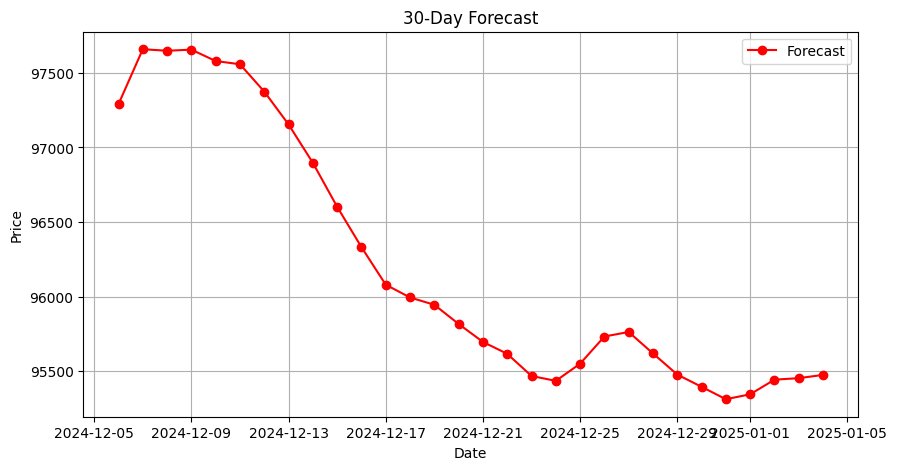

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

def load_data(file_path):
    """Load and preprocess data from CSV."""
    data = pd.read_csv(file_path)
    data = data.rename(columns={
        'Date': 'date', 'Open': 'open', 'High': 'high',
        'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'
    })
    data['date'] = pd.to_datetime(data['date'])
    data.sort_values(by='date', inplace=True)
    return data

def scale_data(data):
    """Scale data using MinMaxScaler."""
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_datasets(data, time_step):
    """Create input-output pairs for training/testing."""
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step, 3])  # Target: Close price
    return np.array(X), np.array(y)

def build_bilstm_model(input_shape):
    """Build and compile the BiLSTM model."""
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(50, return_sequences=False)),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def forecast_next_days(bilstm_model, recent_data, scaler, steps=30):
    """Forecast the next `steps` days using the trained BiLSTM model."""
    forecast = []
    input_data = recent_data.copy()  # Shape: (time_step, features)

    for _ in range(steps):
        # Reshape input data to match LSTM input shape
        input_data_reshaped = input_data.reshape(1, input_data.shape[0], input_data.shape[1])

        # Predict the next step
        predicted = bilstm_model.predict(input_data_reshaped)  # Shape: (1, 1)

        # Inverse scaling to get the actual price
        predicted_full = np.zeros((1, input_data.shape[1]))  # Dummy array
        predicted_full[0, 3] = predicted  # Insert prediction in the Close column
        predicted_price = scaler.inverse_transform(predicted_full)[0, 3]

        forecast.append(predicted_price)

        # Update input_data by appending the predicted value
        new_row = input_data[-1].copy()
        new_row[3] = scaler.transform([[0, 0, 0, predicted_price, 0, 0]])[0, 3]  # Scale Close price
        input_data = np.vstack([input_data[1:], new_row])  # Shift window

    return forecast

def plot_forecast(forecast, last_date):
    """Plot the forecasted prices."""
    forecast_dates = pd.date_range(start=last_date, periods=len(forecast) + 1, freq='D')[1:]
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_dates, forecast, marker='o', color='red', label='Forecast')
    plt.title('30-Day Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def main(file_path):
    """Main function to execute the workflow."""
    # Load and preprocess the data
    data = load_data(file_path)
    features = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
    scaled_data, scaler = scale_data(data[features])

    # Prepare training and testing datasets
    time_step = 30
    X, y = create_datasets(scaled_data, time_step)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Train the BiLSTM model
    bilstm_model = build_bilstm_model((X_train.shape[1], X_train.shape[2]))
    bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Forecast the next 30 days
    recent_data = X_test[-1]  # Use the last window from the test set
    forecast = forecast_next_days(bilstm_model, recent_data, scaler, steps=30)

    # Plot forecast
    plot_forecast(forecast, data['date'].iloc[-1])

# Update file_path with the path to your CSV file
file_path = '/kaggle/input/dataset/cleaned_BTC-USD.csv'
main(file_path)
